Hunter Bennett | Glass Lab | Kupffer Strains Project | 07 May 2021

This notebook will do a basic analysis of motif enrichment in "poised" or "active" enhancers over a generic background

In [5]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/07_Strains_Control_BMDM_MAH_ATAC//'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Call motifs using homer
____
Main difference here is we are just using a general background. This is because most enhancers are 'poised' by our definition within a strain so we just want to get an idea for the enrichment of different motifs within the open chromatin of each sample

In [9]:
strain_dict = {'C57Bl6J': 'c57bl6j',
               'BALBcJ': 'balbcj'}

In [10]:
with open('./findMotifs_poised.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./poised_enhancers/*peaks.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                peakfile, 'mm10', peakfile.replace('_peaks.txt', '_motifs'),
                '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))
    f.close()

# Aggregate results - Homer

In [5]:
glob.glob('./poised_enhancers/*/knownResults.txt')

['./poised_enhancers/BALBcJ_poised_distal_enhancer_motifs/knownResults.txt',
 './poised_enhancers/AJ_poised_distal_enhancer_motifs/knownResults.txt',
 './poised_enhancers/BALBcJ_poised_enhancer_motifs/knownResults.txt',
 './poised_enhancers/C57Bl6J_poised_enhancer_motifs/knownResults.txt',
 './poised_enhancers/C57Bl6J_poised_distal_enhancer_motifs/knownResults.txt',
 './poised_enhancers/AJ_poised_enhancer_motifs/knownResults.txt']

In [6]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./poised_enhancers/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

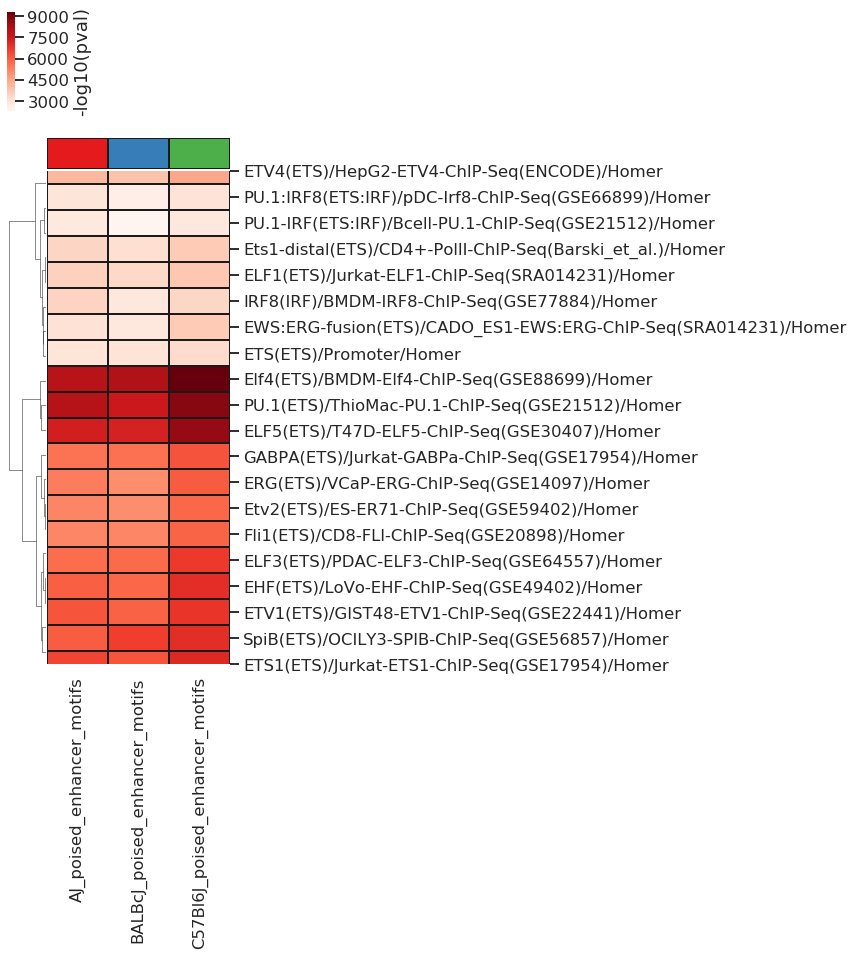

In [7]:
sns.clustermap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=-5).any(axis=1),
                                ~known_motif_pval_frame.columns.str.contains('distal')].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#e41a1c', '#377eb8', '#4daf4a'],
    figsize=(4,12))

plt.savefig('./figures/homer_poised_enhancers_motif_clustermap.png',
            bbox_inches='tight')

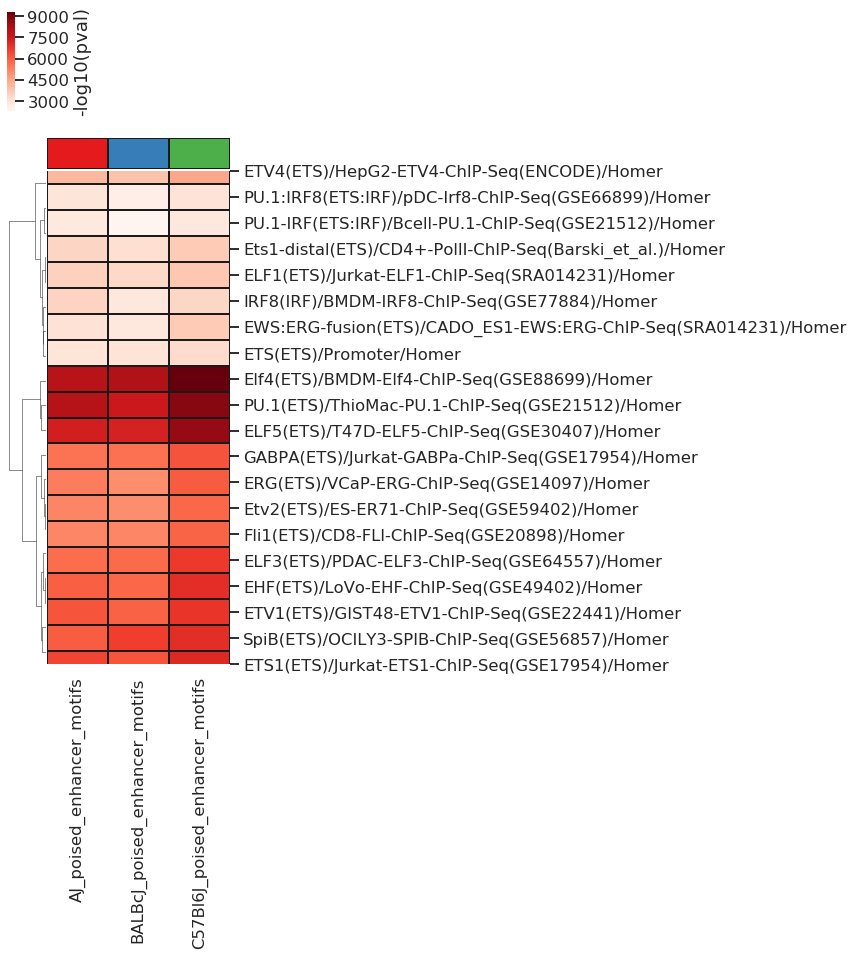

In [8]:
sns.clustermap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=-5).any(axis=1),
                                ~known_motif_pval_frame.columns.str.contains('distal')].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # square=True,
    # center=0,
    # ax=ax,
    col_colors=['#e41a1c', '#377eb8', '#4daf4a'],
    figsize=(4,12))

plt.savefig('./figures/homer_poised_distal_enhancers_motif_clustermap.png',
            bbox_inches='tight')

# Scatter plot comparing motif scores across strains

Goal here is to get a sense for how motif scores (compared to randomly generated background) vary across strain active enhancers

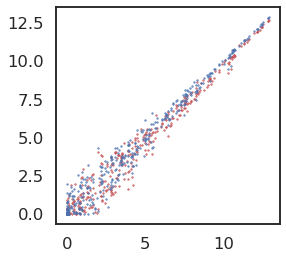

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(np.log2(-known_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-known_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='r')
ax.scatter(np.log2(-known_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-known_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='b')

Text(0, 12, 'R^2=1.00')

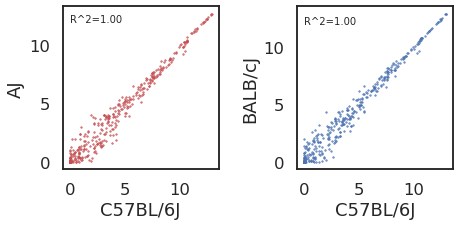

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
plt.subplots_adjust(wspace=.5)
ax1.scatter(np.log2(-known_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-known_motif_pval_frame['AJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='r')
ax1.set_xlabel('C57BL/6J')
ax1.set_ylabel('AJ')
ax1.text(0,12,
         'R^2=%.2f' % known_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                                    'AJ_poised_distal_enhancer_motifs']**2)

ax2.scatter(np.log2(-known_motif_pval_frame['C57Bl6J_poised_distal_enhancer_motifs']+1),
           np.log2(-known_motif_pval_frame['BALBcJ_poised_distal_enhancer_motifs']+1),
           s=0.5,
           c='b')
ax2.set_xlabel('C57BL/6J')
ax2.set_ylabel('BALB/cJ')
ax2.text(0,12,
         'R^2=%.2f' % known_motif_pval_frame.corr().loc['C57Bl6J_poised_distal_enhancer_motifs',
                                                    'BALBcJ_poised_distal_enhancer_motifs']**2)